# Notebook Content

In this notebook, we will apply different techniques to find the best topics modeling, then we will find the best classification model for our new target.

## Import Libraries

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF , TruncatedSVD 
from gensim import models, matutils
from collections import Counter
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import scattertext as st
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.symbols import amod
from pprint import pprint
from nltk.probability import FreqDist
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report ,accuracy_score
from sklearn.linear_model import LogisticRegression
from corextopic import corextopic as ct
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pickle

# Read data from SQL

In [2]:
connection= sql.connect('cleaned_rev.db')

In [3]:
df = pd.read_sql('SELECT * FROM cleaned_rev', connection)

### Drop Index Column

In [4]:
df.drop('index', axis=1, inplace=True)

In [5]:
df.head()

,Description,Description_stemmed,Description_lemmed,sentiment
0,room kind clean strong smell dogs generally av...,room kind clean strong smell dog gener averag ...,kind strong smell dog generally average overni...,negative
1,stayed crown plaza april april staff friendly ...,stay crown plaza april april staff friendli at...,crown plaza april april attentive elevators ti...,negative
2,booked hotel hotwire lowest price could find g...,book hotel hotwir lowest price could find got ...,hotwire low smoke argue baby smoke hear anythi...,negative
3,stayed husband sons way alaska cruise loved ho...,stay husband son way alaska cruis love hotel g...,husband sons way alaska cruise love experience...,positive
4,girlfriends stayed celebrate th birthdays plan...,girlfriend stay celebr th birthday plan weeken...,girlfriends celebrate birthdays plan weekend g...,negative


## PipeLine 

In [6]:
# To separate all words in each review
df['spacy_doc'] = list(nlp.pipe(df.Description_lemmed))

In [7]:
# Total words in each review
df['len_words'] = df.spacy_doc.apply(lambda x: len(x))

In [8]:
df

,Description,Description_stemmed,Description_lemmed,sentiment,spacy_doc,len_words
0,room kind clean strong smell dogs generally av...,room kind clean strong smell dog gener averag ...,kind strong smell dog generally average overni...,negative,"(kind, strong, smell, dog, generally, average,...",10
1,stayed crown plaza april april staff friendly ...,stay crown plaza april april staff friendli at...,crown plaza april april attentive elevators ti...,negative,"(crown, plaza, april, april, attentive, elevat...",64
2,booked hotel hotwire lowest price could find g...,book hotel hotwir lowest price could find got ...,hotwire low smoke argue baby smoke hear anythi...,negative,"(hotwire, low, smoke, argue, baby, smoke, hear...",69
3,stayed husband sons way alaska cruise loved ho...,stay husband son way alaska cruis love hotel g...,husband sons way alaska cruise love experience...,positive,"(husband, sons, way, alaska, cruise, love, exp...",37
4,girlfriends stayed celebrate th birthdays plan...,girlfriend stay celebr th birthday plan weeken...,girlfriends celebrate birthdays plan weekend g...,negative,"(girlfriends, celebrate, birthdays, plan, week...",89
...,...,...,...,...,...,...
38927,arrived late night walked check area completel...,arriv late night walk check area complet flood...,arrive late completely flood fan run everywher...,positive,"(arrive, late, completely, flood, fan, run, ev...",36
38928,positive impression location public parking op...,posit impress locat public park opposit site s...,positive impression public park opposite site ...,negative,"(positive, impression, public, park, opposite,...",34
38929,traveling friends shopping show location great...,travel friend shop show locat great best say r...,travel friends shop show best average hallway ...,negative,"(travel, friends, shop, show, best, average, h...",58
38930,experience ok paid extra view pool got view pa...,experi ok paid extra view pool got view palm t...,experience pay extra view pool view palm tree ...,negative,"(experience, pay, extra, view, pool, view, pal...",35


## Scatter Plot

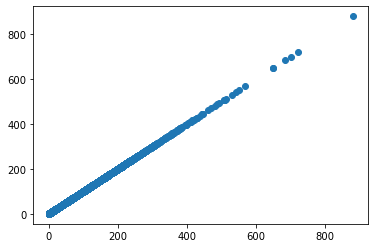

In [9]:
# Scatter plot that represents count number of words in each review 
plt.scatter(df.len_words,df.len_words);

## Drop rows

In [10]:
# Drop reviews with more than 200 words
df=df[df.len_words<200]

## Scatter Text 

In [11]:
# Sample from the data
df_temp = df[:2000]

In [12]:
corpus = st.CorpusFromPandas(df_temp,
                             category_col='sentiment',
                             text_col='Description_lemmed',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [13]:
html = st.produce_scattertext_explorer(
        corpus,
        category='positive',
        category_name='Positive',
        not_category_name='Negative',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=df_temp['Description_lemmed'],
        )

In [14]:
open('reviews.html', 'wb').write(html.encode('utf-8'));

## Count Positive and Negative Reviews

In [15]:
# Put positive and negative reviews in seperate dataframes.
positive_reviews = df[df.sentiment=='positive']
negative_reviews = df[df.sentiment=='negative']

### Explore Adjs and Nouns in Reviews

In [16]:
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='NOUN']

In [93]:
# count the most common words in positive adjectives 
pos_adj=Counter(pos_adj)

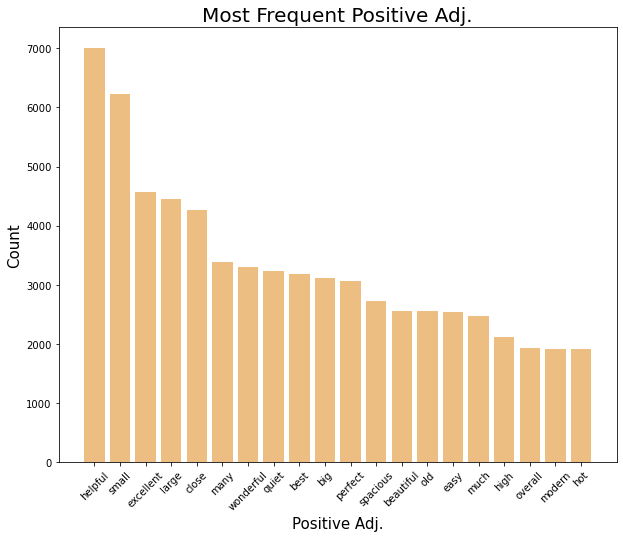

In [94]:
fre_p=FreqDist(pos_adj)
fre_p.most_common()
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.xlabel('Positive Adj.', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Most Frequent Positive Adj.', fontsize=20)
for k, v in fre_p.most_common(20):
    plt.bar(k,v, color='#ECBE81')

In [87]:
# count the most common words in negative adjectives 
neg_adj=Counter(neg_adj)

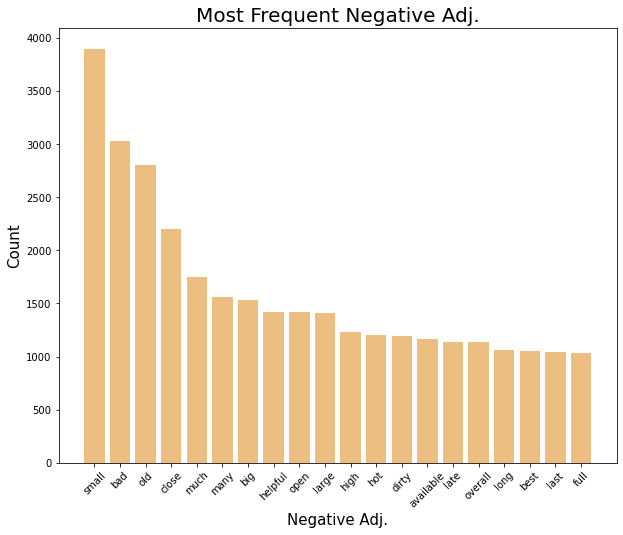

In [91]:
fre_n=FreqDist(neg_adj)
fre_n.most_common()
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.xlabel('Negative Adj.', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Most Frequent Negative Adj.', fontsize=20)
for k, v in fre_n.most_common(20):
    plt.bar(k,v, color='#ECBE81')

In [95]:
# count the most common words in positive nouns 
pos_nouns=Counter(pos_noun)

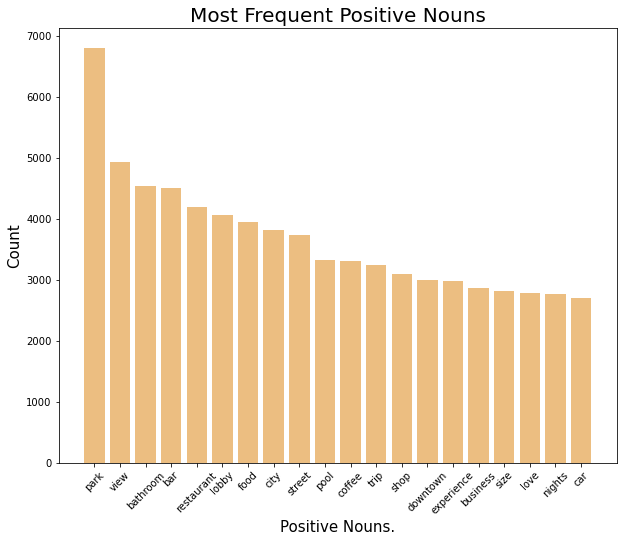

In [96]:
fre_pn=FreqDist(pos_nouns)
fre_pn.most_common()
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.xlabel('Positive Nouns.', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Most Frequent Positive Nouns', fontsize=20)
for k, v in fre_pn.most_common(20):
    plt.bar(k,v, color='#ECBE81')

In [97]:
# count the most common words in negative nouns 
neg_nouns=Counter(neg_noun)

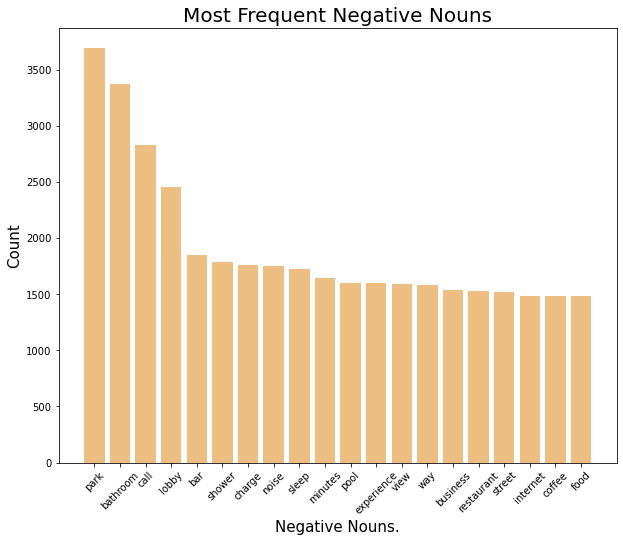

In [99]:
fre_nn=FreqDist(neg_nouns)
fre_nn.most_common()
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.xlabel('Negative Nouns.', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Most Frequent Negative Nouns', fontsize=20)
for k, v in fre_nn.most_common(20):
    plt.bar(k,v, color='#ECBE81')

In [21]:
def get_amods(noun, ser):
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        if child.text.lower() not in amod_list: 
                            amod_list.append(child.text.lower())
    return sorted(amod_list)

def amods_by_sentiment(noun):
    print(f"Adjectives describing {str.upper(noun)}:\n")
    
    print("POSITIVE:")
    pprint(get_amods(noun, positive_reviews.spacy_doc))
    
    print("\nNEGATIVE:")
    pprint(get_amods(noun, negative_reviews.spacy_doc))

In [84]:
amods_by_sentiment("resort")

Adjectives describing RESORT:

POSITIVE:
['adjacent',
 'beautiful',
 'believe',
 'best',
 'big',
 'broadmoor',
 'cheap',
 'classic',
 'close',
 'complete',
 'decent',
 'different',
 'efficient',
 'elegant',
 'enormous',
 'enough',
 'entire',
 'european',
 'excellent',
 'expensive',
 'fabulous',
 'fair',
 'fancy',
 'fantastic',
 'far',
 'felt',
 'fine',
 'flat',
 'forward',
 'fourth',
 'french',
 'full',
 'functional',
 'grand',
 'happy',
 'helpful',
 'incorporate',
 'incredible',
 'intimate',
 'large',
 'last',
 'leery',
 'less',
 'long',
 'lovely',
 'lucky',
 'many',
 'marry',
 'marvellous',
 'marvelous',
 'massive',
 'modern',
 'much',
 'nearby',
 'non',
 'notch',
 'offerred',
 'old',
 'onsite',
 'outdoor',
 'outstanding',
 'overall',
 'perfect',
 'pleasant',
 'plenty',
 'qualify',
 'real',
 'receive',
 'recommend',
 'recreational',
 'regular',
 'rich',
 'romantic',
 'safe',
 'several',
 'silly',
 'situate',
 'sleek',
 'slow',
 'small',
 'socal',
 'spacious',
 'special',
 'standard',

## Topic Modeling with Matrix Factorization

### Count Vectorizer

In [23]:
count_vectorizer = CountVectorizer(stop_words='english')

doc_word = count_vectorizer.fit_transform(df.Description_lemmed)
pd.DataFrame(doc_word.toarray(), columns=count_vectorizer.get_feature_names())

,aa,aain,aarhus,aaron,aarp,aarron,aas,aatc,aau,aavacations,...,zucchini,zucker,zuckers,zuerich,zuli,zuma,zumba,zupito,zurich,zzip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
count_vectorizer_ngram = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
doc_word_ngram = count_vectorizer_ngram.fit_transform(df.Description_lemmed)
pd.DataFrame(doc_word_ngram.toarray(), columns=count_vectorizer_ngram.get_feature_names())


,aa,aa center,aa delay,aa everytime,aa group,aa husband,aa md,aa recommend,aa vacation,aain,...,zuma,zuma beach,zumba,zumba husband,zupito,zupito cater,zurich,zurich spring,zzip,zzip member
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Tfidf Vectorizer 

In [25]:
Tf_vectorizer=TfidfVectorizer()
tfidf_doc=Tf_vectorizer.fit_transform(df.Description_lemmed)
tfidf=pd.DataFrame(tfidf_doc.toarray(), columns=Tf_vectorizer.get_feature_names())

In [26]:
tfidf.head()

,aa,aain,aarhus,aaron,aarp,aarron,aas,aatc,aau,aavacations,...,zucchini,zucker,zuckers,zuerich,zuli,zuma,zumba,zupito,zurich,zzip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1- Latent Semantic Analysis (LSA)

In [27]:
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.01993685, 0.01048835, 0.00788112, 0.00743255, 0.00631296])

In [28]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = count_vectorizer.get_feature_names())
topic_word

,aa,aain,aarhus,aaron,aarp,aarron,aas,aatc,aau,aavacations,...,zucchini,zucker,zuckers,zuerich,zuli,zuma,zumba,zupito,zurich,zzip
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
component_3,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_4,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_5,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0


In [29]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\n Topic ", ix)
        else:
            print("\n Topic ",topic_names[ix], "'")
        print(",".join([feature_names[i]
                       for i in topic.argsort()[:-no_top_words -1:-1]])) 

display_topics(lsa, count_vectorizer.get_feature_names(), 10)


 Topic  0
park,small,bathroom,view,lobby,close,bar,street,helpful,large

 Topic  1
park,car,valet,garage,street,charge,pay,downtown,drive,fee

 Topic  2
bathroom,bad,pay,leave,charge,shower,small,old,sleep,late

 Topic  3
small,bathroom,street,park,square,shower,size,large,tv,lobby

 Topic  4
pool,bar,small,restaurant,lobby,food,kid,large,hot,view


In [30]:
Vt=pd.DataFrame(doc_topic.round(5),
                index=df['Description_lemmed'],
                columns=["component_1","component_2","component_3","component_4","component_5"])
Vt

,component_1,component_2,component_3,component_4,component_5
Description_lemmed,,,,,
kind strong smell dog generally average overnight fussy consider nothing,0.14323,-0.00830,0.14387,-0.02990,0.00645
crown plaza april april attentive elevators tiny food restaurant delicious high side course washington dc pool children fifth plenty space person tv small todays standards limit number channel small bite mold bathtub remove bleach appear carpet vacummed every report light bulb burn never replace ice machine odd number encounter elevator mention ice machine severel hours late maid appear ice mint sure unnerve business vacation,1.89432,-0.65311,0.66371,0.69458,1.35034
hotwire low smoke argue baby smoke hear anything hotwire cheap available unhappy deal persuasion discussion nonsmoking thereafter minimal amenities besides near dupont circle much overprice small condition bathroom small tub bathroom amenities minimal fridge microwave rent fridge keep baby park cost per best drive lobby small feel old thing available coffee lobby decent poor minimal amenities small small bathrooms view distance metro either mcpherson station dupont station try available,3.38883,-0.39706,1.30598,3.80479,1.20098
husband sons way alaska cruise love experience north tower face north west best view high stun view needle city cruise ship order dinner enjoy perfect view dinners delicious perfect spot everywhere enjoy city almost forget heavenly heavenly,1.54229,-0.23982,-1.77536,-0.54699,-0.03705
girlfriends celebrate birthdays plan weekend getaway february forward rent ajoining rate nights tax park charge spend total expect certain level since ritz however certainly meet consider ritz standards fine well appoint bathrooms nothing excite however awful call bell man someone communications pick phone saturday leave dinner request extra deliver trash remove return neither request call housekeep finally care opinion rat pay nightly turn speak worth return however receive letter apology needle plan return husband four season boston february wonderful impeccable four seaons pay ritz carlton recommend four season instead,2.34401,0.66904,0.84434,-1.49667,-0.79851
...,...,...,...,...,...
arrive late completely flood fan run everywhere damage ceilings wall computers computer office mention condition understandable women behind unfriendly opposite quickly possible okay plenty choices kind late biscuits hard fruit seem old sure arrive early definitely,0.96663,-0.28423,0.66585,-0.59398,-0.32460
positive impression public park opposite site street modest spartan upgrade shower wc sfo pay choose however porridge toast fruit egg etc minutes away cafe de la presse https map google ru map hl ru,0.97324,0.90529,0.19286,0.16469,-0.26412
travel friends shop show best average hallway carpet stain buckle many couch carpet stain fluffy robe throw none upon leave call minutes ahead ahead car instruct bell man cab wait car wait minutes stand bell stand disappear inside receptionist forget busy wait apologize wait minutes help explain situation point bell man busy rudely mumble leave bad customer mistake,1.72072,0.08885,1.31296,-1.62620,-0.63329


As seen, there are no correlations between the words. As a result, we will try differents techniques

## 2- Non-Negative Matrix Factorization (NMF)

In [31]:
nmf_model = NMF(5)
doc_topic_nmf = nmf_model.fit_transform(doc_word)


/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [32]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = count_vectorizer.get_feature_names())
topic_word

,aa,aain,aarhus,aaron,aarp,aarron,aas,aatc,aau,aavacations,...,zucchini,zucker,zuckers,zuerich,zuli,zuma,zumba,zupito,zurich,zzip
component_1,0.001,0.001,0.0,0.001,0.005,0.0,0.000,0.000,0.000,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.001,0.0,0.0
component_2,0.001,0.000,0.0,0.000,0.000,0.0,0.001,0.000,0.000,0.0,...,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
component_3,0.000,0.000,0.0,0.001,0.001,0.0,0.000,0.000,0.000,0.0,...,0.000,0.001,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
component_4,0.000,0.000,0.0,0.000,0.001,0.0,0.000,0.001,0.001,0.0,...,0.001,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.0
component_5,0.003,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.001,0.0,...,0.000,0.000,0.0,0.003,0.0,0.002,0.001,0.000,0.0,0.0


In [33]:
display_topics(nmf_model, count_vectorizer.get_feature_names(), 10)


 Topic  0
leave,pay,late,arrive,bad,wait,charge,try,minutes,sleep

 Topic  1
park,car,valet,street,garage,pay,downtown,charge,close,drive

 Topic  2
view,helpful,city,recommend,square,excellent,street,restaurant,bar,shop

 Topic  3
small,bathroom,shower,lobby,large,size,tv,old,coffee,bite

 Topic  4
pool,kid,bar,food,restaurant,hot,enjoy,family,resort,view


As seen, there is a correlation between the words. So we can generate the topics.  

The topics are: **Procedures**,**Parking**,**General Atmosphere**,**Room Facilities**, and **Resort Hotel**.

In [34]:
VT = pd.DataFrame(doc_topic.round(5),
             index = df['Description_lemmed'],
             columns = ["component_1","component_2","component_3","component_4","component_5"])
VT

,component_1,component_2,component_3,component_4,component_5
Description_lemmed,,,,,
kind strong smell dog generally average overnight fussy consider nothing,0.14323,-0.00830,0.14387,-0.02990,0.00645
crown plaza april april attentive elevators tiny food restaurant delicious high side course washington dc pool children fifth plenty space person tv small todays standards limit number channel small bite mold bathtub remove bleach appear carpet vacummed every report light bulb burn never replace ice machine odd number encounter elevator mention ice machine severel hours late maid appear ice mint sure unnerve business vacation,1.89432,-0.65311,0.66371,0.69458,1.35034
hotwire low smoke argue baby smoke hear anything hotwire cheap available unhappy deal persuasion discussion nonsmoking thereafter minimal amenities besides near dupont circle much overprice small condition bathroom small tub bathroom amenities minimal fridge microwave rent fridge keep baby park cost per best drive lobby small feel old thing available coffee lobby decent poor minimal amenities small small bathrooms view distance metro either mcpherson station dupont station try available,3.38883,-0.39706,1.30598,3.80479,1.20098
husband sons way alaska cruise love experience north tower face north west best view high stun view needle city cruise ship order dinner enjoy perfect view dinners delicious perfect spot everywhere enjoy city almost forget heavenly heavenly,1.54229,-0.23982,-1.77536,-0.54699,-0.03705
girlfriends celebrate birthdays plan weekend getaway february forward rent ajoining rate nights tax park charge spend total expect certain level since ritz however certainly meet consider ritz standards fine well appoint bathrooms nothing excite however awful call bell man someone communications pick phone saturday leave dinner request extra deliver trash remove return neither request call housekeep finally care opinion rat pay nightly turn speak worth return however receive letter apology needle plan return husband four season boston february wonderful impeccable four seaons pay ritz carlton recommend four season instead,2.34401,0.66904,0.84434,-1.49667,-0.79851
...,...,...,...,...,...
arrive late completely flood fan run everywhere damage ceilings wall computers computer office mention condition understandable women behind unfriendly opposite quickly possible okay plenty choices kind late biscuits hard fruit seem old sure arrive early definitely,0.96663,-0.28423,0.66585,-0.59398,-0.32460
positive impression public park opposite site street modest spartan upgrade shower wc sfo pay choose however porridge toast fruit egg etc minutes away cafe de la presse https map google ru map hl ru,0.97324,0.90529,0.19286,0.16469,-0.26412
travel friends shop show best average hallway carpet stain buckle many couch carpet stain fluffy robe throw none upon leave call minutes ahead ahead car instruct bell man cab wait car wait minutes stand bell stand disappear inside receptionist forget busy wait apologize wait minutes help explain situation point bell man busy rudely mumble leave bad customer mistake,1.72072,0.08885,1.31296,-1.62620,-0.63329


## Topic Modeling with gensim

## Latent Dirichlet Allocation (LDA)

In [35]:
# Transpose it so the terms are the rows
doc_words = count_vectorizer.transform(df['Description_lemmed']).transpose()

pd.DataFrame(doc_words.toarray(), count_vectorizer.get_feature_names())

,0,1,2,3,4,5,6,7,8,9,...,38316,38317,38318,38319,38320,38321,38322,38323,38324,38325
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aarhus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaron,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aarp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuma,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zumba,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zupito,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zurich,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_words)

In [37]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [38]:
len(id2word)

36456

In [39]:
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=5)

In [40]:
lda.print_topics()

[(0,
  '0.011*"view" + 0.010*"pool" + 0.009*"bar" + 0.008*"enjoy" + 0.008*"love" + 0.008*"wonderful" + 0.007*"beautiful" + 0.007*"experience" + 0.007*"restaurant" + 0.007*"best"'),
 (1,
  '0.018*"park" + 0.010*"close" + 0.009*"street" + 0.008*"airport" + 0.008*"coffee" + 0.007*"helpful" + 0.007*"car" + 0.006*"easy" + 0.006*"downtown" + 0.006*"small"'),
 (2,
  '0.017*"square" + 0.013*"small" + 0.012*"nyc" + 0.011*"helpful" + 0.011*"york" + 0.010*"city" + 0.009*"view" + 0.009*"central" + 0.008*"recommend" + 0.008*"subway"'),
 (3,
  '0.015*"bathroom" + 0.012*"shower" + 0.009*"old" + 0.009*"small" + 0.008*"wall" + 0.008*"bad" + 0.008*"sleep" + 0.007*"noise" + 0.007*"tv" + 0.007*"lobby"'),
 (4,
  '0.011*"leave" + 0.010*"charge" + 0.009*"arrive" + 0.009*"pay" + 0.008*"late" + 0.008*"wait" + 0.007*"park" + 0.006*"minutes" + 0.006*"try" + 0.005*"phone"')]

The words are not very related to each other. So, we will skip this model. 

## 3- CorEx model

In [41]:
words = list(np.asarray(count_vectorizer.get_feature_names()))
topic_model = ct.Corex(n_hidden=5, 
                       words=words,
                       max_iter=100, 
                       seed=42)

doc_topic_corex= topic_model.fit_transform(doc_word, words=words, docs=df['Description_lemmed'],
                anchors=[['leave', 'late'], ['bathroom', 'shower'], 
                         ['coffee', 'restaurant'],
                        ['helpful', 'helpful', 'recommend'], 
                         ['resort', 'pool', 'kid']], anchor_strength=10)

#tf idf
words = list(np.asarray(Tf_vectorizer.get_feature_names()))
topic_model_2 = ct.Corex(n_hidden=5, 
                       words=words,
                       max_iter=100, 
                       seed=42)
topic_model_2.fit(tfidf_doc, words=words, docs=df['Description_lemmed'])

In [42]:
# function for displaying the words in each topic to be used for CorEx model.
def corex_topics(topic_model):
    topics = topic_model.get_topics()
    return topics
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('Topic {} keywords: '.format(n) + ', '.join(topic_words))

#### CorEx model using feature extracted from Countvectorizer

In [43]:
topics = corex_topics(topic_model)
topic_num=0
for topic in topics:
    print("topic ",topic_num, ":")
    for word in topic:
        print(word[0], end=", ")
    print(" ")
    print(" ")
    topic_num=topic_num+1

topic  0 :
leave, late, arrive, try, pay, open, wait, minutes, bad, turn,  
 
topic  1 :
bathroom, shower, small, sink, tv, pressure, tub, toilet, size, towel,  
 
topic  2 :
restaurant, coffee, tea, maker, bar, food, eat, juice, fruit, cup,  
 
topic  3 :
helpful, recommend, highly, definitely, extremely, concierge, friends, subway, directions, polite,  
 
topic  4 :
pool, kid, resort, swim, indoor, outdoor, spa, children, hot, family,  
 


#### CorEx model using feature extracted from TF-IDF 

In [44]:
topics = corex_topics(topic_model_2)
topic_num=0
for topic in topics:
    print("topic ",topic_num, ":")
    for word in topic:
        print(word[0], end=", ")
    print(" ")
    print(" ")
    topic_num=topic_num+1

topic  0 :
dirty, call, stain, smoke, smell, carpet, bad, disgust, filthy, sheet,  
 
topic  1 :
que, muy, esta, owesome, birthay, outystanding, venable, vcredibly, quita, dirtyroom,  
 
topic  2 :
locationa, dnq, suoer, rawlins, heller, evita, caren, platinums, platimum, plasure,  
 
topic  3 :
blacksher, amina, disign, izekaya, awersome, stnads, medidien, withfamily, breakfastsonly, newy,  
 
topic  4 :
purdy, defentely, arrangemnts, anniversery, iwould, photograghs, hotwl, righht, andthe, quck,  
 


The words are not very related to each other. So, we will skip this model.

After applying some models, the best topics results are with **NMF** model.

## Approve The Model 

In [45]:
topics_by_hotel = pd.DataFrame(doc_topic_nmf, columns = ['Procedures', 'Parking','General Atmosphere',
                                                           'Room Facilities','Resort Hotel'])
topics_by_hotel['main_topic'] = topics_by_hotel.idxmax(axis=1)
topics_by_hotel['Description_lemmed'] = df['Description_lemmed']
topics_by_hotel['Description'] = df['Description']
topics_by_hotel['sentiment'] = df['sentiment']

In [46]:
topics_by_hotel.sample(10)

,Procedures,Parking,General Atmosphere,Room Facilities,Resort Hotel,main_topic,Description_lemmed,Description,sentiment
2627,0.000000,0.066057,0.139477,0.009156,0.000000,General Atmosphere,arrive early due flight change agent quick pho...,arrived early due flight change front desk age...,positive
33885,0.005933,0.085372,0.026470,0.012825,0.000000,Parking,kimpton properties horrible wireless network a...,nice hotel kimpton properties horrible wireles...,negative
3014,0.041085,0.000000,0.151393,0.048264,0.000000,General Atmosphere,partner end april situate especially broadway ...,partner stayed end april hotel the hotel situa...,negative
25127,0.000000,0.073551,0.133538,0.000000,0.000000,General Atmosphere,june impress admit bad bad thing spacious help...,stayed june impressed admit bad area bad thing...,positive
30451,0.033125,0.000000,0.000000,0.000000,0.553649,Resort Hotel,business group co workers company travel guy b...,stayed business group co workers booked compan...,positive
7113,0.057884,0.000000,0.026156,0.034507,0.000000,Procedures,pick online information bite pricey felt etc w...,picked hotel online information knew bit price...,positive
25176,0.000000,0.006254,0.084059,0.003195,0.003825,General Atmosphere,definitely stylish wifi bathrooms cool fancy i...,definitely likes one rooms stylish comfortable...,positive
25810,0.082391,0.099144,0.042115,0.070418,0.045151,Parking,basic nyc sit fantastic centre square accommod...,hotel basic go nyc sit hotel room location fan...,positive
35969,0.015588,0.000000,0.043183,0.000000,0.006704,General Atmosphere,review mention elevators small slow much probl...,reviews mentioned elevators small slow much pr...,negative
20490,0.035235,0.001758,0.118568,0.063342,0.000000,General Atmosphere,plusses minuses despite thin wall sometimes th...,lots plusses minuses hotel despite thin walls ...,positive


## Plot Number of Reviews per Topic

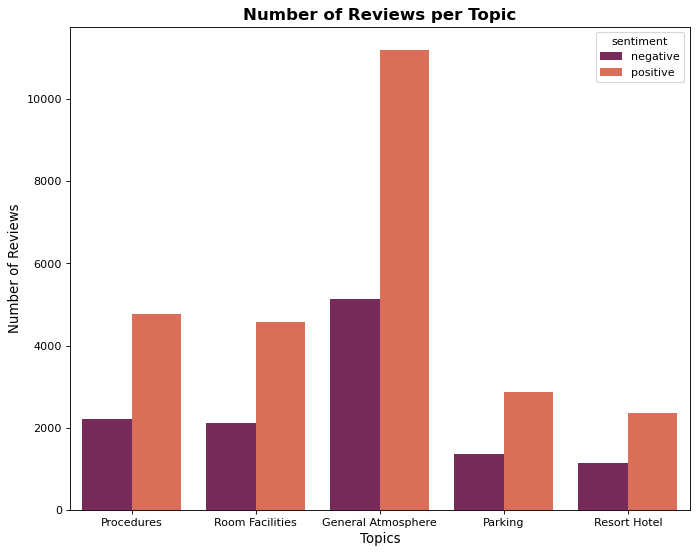

In [47]:
plt.figure(figsize=(10, 8), dpi=80)

Gender_col = sns.countplot(x="main_topic", hue = 'sentiment', data=topics_by_hotel, palette="rocket")
Gender_col.set_ylabel('Number of Reviews', size= 12) 
Gender_col.set_xlabel('Topics', size= 12)
Gender_col.set_title('Number of Reviews per Topic', weight = 'bold', size =15);

**As seen in above graph, the positive reviews are higer thann negative reviews in all topics.**  

## PCA

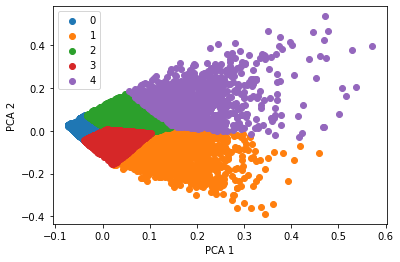

In [82]:
pca = PCA(2)
df = pca.fit_transform(doc_topic_nmf)
kmeans = KMeans(n_clusters= 5)
label = kmeans.fit_predict(df)
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig('pca');
plt.show()

## Visualize TSNE

In [49]:
tsne= TSNE(n_components=2, random_state=0, verbose=0)
tsne_result= tsne.fit_transform(doc_topic_nmf)

In [56]:
topics_by_hotel['X_tsne'] =tsne_result[:, 0]
topics_by_hotel['Y_tsne'] =tsne_result[:, 1]

In [57]:
topics_by_hotel

,Procedures,Parking,General Atmosphere,Room Facilities,Resort Hotel,main_topic,Description_lemmed,Description,sentiment,X_tsne,Y_tsne
0,0.010441,0.001940,0.000000,0.003608,0.000454,Procedures,kind strong smell dog generally average overni...,room kind clean strong smell dogs generally av...,negative,11.274722,66.334282
1,0.038870,0.000000,0.000000,0.148541,0.109743,Room Facilities,crown plaza april april attentive elevators ti...,stayed crown plaza april april staff friendly ...,negative,-64.198578,0.691287
2,0.000000,0.074824,0.000000,0.434738,0.000000,Room Facilities,hotwire low smoke argue baby smoke hear anythi...,booked hotel hotwire lowest price could find g...,negative,-43.038242,-12.960019
3,0.000000,0.000000,0.186088,0.000000,0.011209,General Atmosphere,husband sons way alaska cruise love experience...,stayed husband sons way alaska cruise loved ho...,positive,17.168022,-36.956844
4,0.162192,0.078244,0.035173,0.000000,0.000000,Procedures,girlfriends celebrate birthdays plan weekend g...,girlfriends stayed celebrate th birthdays plan...,negative,-23.405613,-35.472679
...,...,...,...,...,...,...,...,...,...,...,...
38321,0.087806,0.000000,0.000000,0.005635,0.000000,Procedures,allerton vintage jewel heart city old historic...,allerton hotel vintage jewel heart city hotel ...,positive,-9.837840,29.886980
38322,0.022983,0.086868,0.016200,0.015893,0.000000,Parking,pay dollars nothing bedbugs dad bite rd old mu...,payed dollars nothing bedbugs dad got bit rd n...,negative,5.171100,-68.468338
38323,0.180768,0.017344,0.000000,0.000000,0.000000,Procedures,long term minute metro cvs across street,good long term stay hotel clean good staff min...,positive,-17.713846,10.395718
38324,0.027160,0.074353,0.000000,0.000000,0.167697,Resort Hotel,fly la london arrive late whole la leave early...,flew la london arriving late one whole day la ...,negative,-52.652386,-22.105488


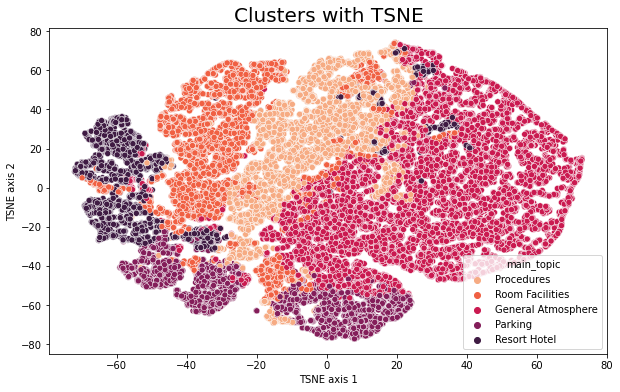

In [58]:
plt.figure(figsize=(10,6))
plt.title("Clusters with TSNE", fontsize=20)
plt.xlabel('TSNE axis 1')
plt.ylabel('TSNE axis 2')
sns.scatterplot(
    x="X_tsne", y="Y_tsne",
    hue=topics_by_hotel['main_topic'],
    palette=sns.color_palette("rocket_r", 5),
    data=topics_by_hotel,
    legend="full"
);

**As seen, the clusters are presented with each review's distance.**

## WordCloud 

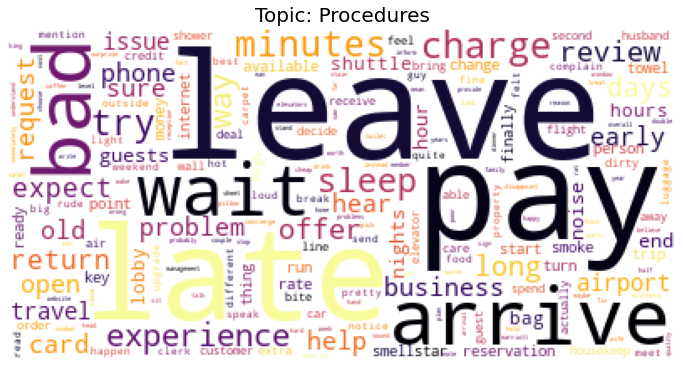

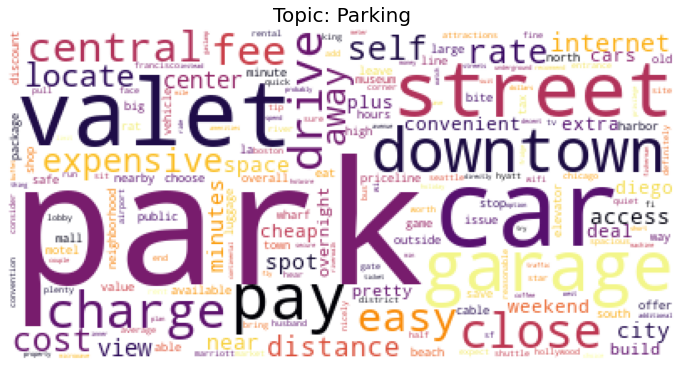

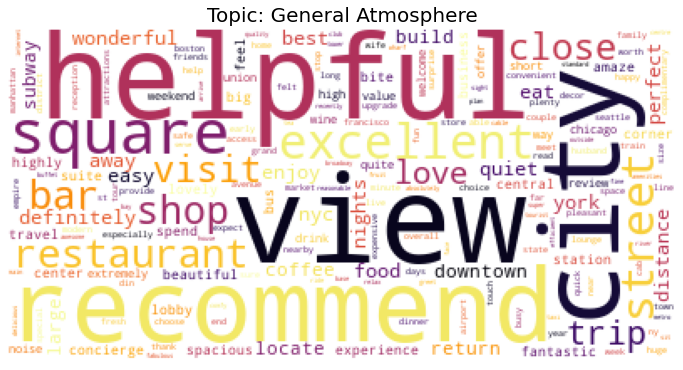

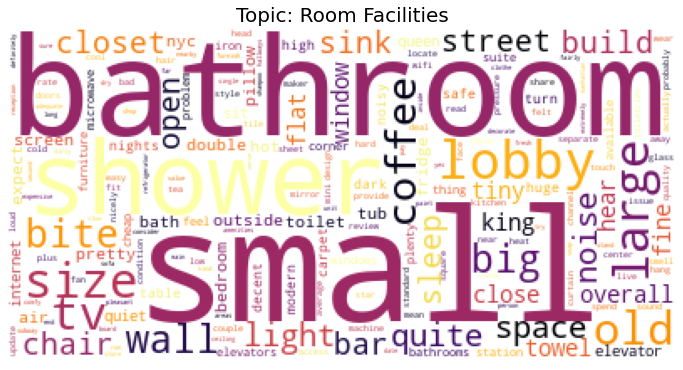

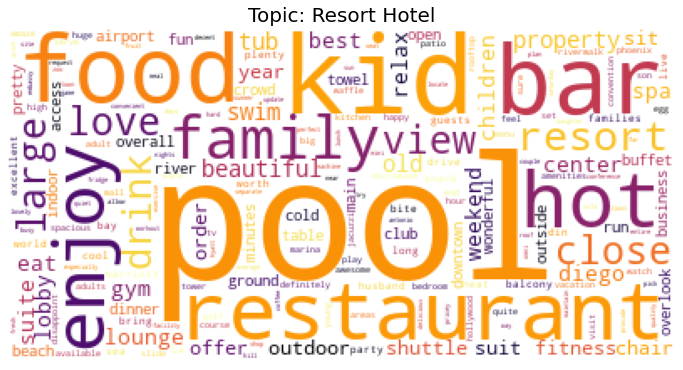

In [53]:
def get_word_freq(topic, model, n_top_words, vocab):
    """
    This method will be called to count the most frequent words in specific topic.
    """
 
    word_dict = {};
    freq = sorted(model.components_[topic])[:-n_top_words - 1: -1]
    words_ids = model.components_[topic].argsort()[:-n_top_words - 1:-1]
    words = [vocab[key] for key in words_ids]
    for i in range(n_top_words):
        word_dict[words[i]] = freq[i]

    
    return word_dict
vocab=count_vectorizer.get_feature_names()
list_of_topics= ['Procedures', 'Parking','General Atmosphere','Room Facilities','Resort Hotel']
for topic in range(5):
    plt.figure(figsize = (12,14))
    plt.imshow(WordCloud(background_color='white', colormap=plt.cm.inferno).fit_words(dict(get_word_freq(topic, nmf_model, 200, vocab))))
    plt.axis('off')
    plt.title('Topic: ' + list_of_topics[topic], size=20)
    plt.show();

## Clustering

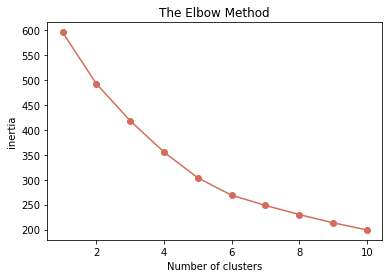

In [78]:
inertia=[]
list_num_clusters=list(range(1,11))
for num_clusters in list_num_clusters:
    km=KMeans(n_clusters=num_clusters)
    km.fit(doc_topic_nmf)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters, inertia, color= '#D56C5B')
plt.scatter(list_num_clusters, inertia, color= '#D56C5B')
plt.title('The Elbow Method')
plt.xlabel("Number of clusters")
plt.ylabel("inertia");
plt.savefig('elbow')

**In terms of the Elbow result, the number of topics is fine-tuned as 5.**

## Split Data

In [61]:
X= doc_topic_nmf
y = topics_by_hotel.main_topic 

In [62]:
X_train, X_test, y_train, y_test= train_test_split(X, y , test_size = .2, random_state= 42)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train , test_size = .2, random_state= 42)

# Apply Classification Algorithm 

## Accuracy Score Calculation Method 

In [63]:
def cal_score(X_train_f, X_val_f, y_train_f, y_val_f):
    """
    This method will be called to fit the training and validation sets with score for all models.
    """
    models = [LogisticRegression(C=1000),RandomForestClassifier(), BernoulliNB(),
                  MultinomialNB(),GaussianNB()]
    models_names= ['LogisticRegression',
              'RandomForestClassifier' , 'BernoulliNB' ,
              'MultinomialNB' ,'GaussianNB']
    i=0
    for model in models:
        mod= OneVsRestClassifier(model).fit(X_train_f, y_train_f)
        t_score=mod.score(X_train_f, y_train_f)
        v_score=mod.score(X_val_f, y_val_f)
        print('Training accuracy score in {0} {1:.9f}'.format(models_names[i],t_score))
        print('Validation accuracy score in {0} {1:.9f}'.format(models_names[i],v_score))
        print('------------------------------------------------------')
        print()
        i+=1

In [64]:
# Call the method to calculte accuracy scores 
cal_score(X_train, X_val, y_train, y_val)

Training accuracy score in LogisticRegression 0.968525766
Validation accuracy score in LogisticRegression 0.966894977
------------------------------------------------------

Training accuracy score in RandomForestClassifier 1.000000000
Validation accuracy score in RandomForestClassifier 0.981245923
------------------------------------------------------

Training accuracy score in BernoulliNB 0.484385192
Validation accuracy score in BernoulliNB 0.497390737
------------------------------------------------------

Training accuracy score in MultinomialNB 0.431343770
Validation accuracy score in MultinomialNB 0.440965427
------------------------------------------------------

Training accuracy score in GaussianNB 0.799902153
Validation accuracy score in GaussianNB 0.805772994
------------------------------------------------------



Based on previous results, we choose **RandomForestClassifier** as a best model with training, and validation accuracy scores **1.0** , and **0.98** respectively.

## GridSearch

In [65]:
rd_range = list(range(1, 200, 10))
param_grid = dict(n_estimators=rd_range)
print(param_grid)

{'n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191]}


In [66]:
randomforest = RandomForestClassifier()
grid = GridSearchCV(randomforest, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_estimators': 181}
Best estimator:  RandomForestClassifier(n_estimators=181)
Best score:  0.9808790584081652


As we see, the best value of n_estimators in RandomForestClassifier model is **81**

## Test The model 

In [67]:
rfc=OneVsRestClassifier(RandomForestClassifier(n_estimators=81)).fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print('RandomForestClassifier training score: ',rfc.score(X_train,y_train))
print('RandomForestClassifier testing score: ',rfc.score(X_test,y_test))

RandomForestClassifier training score:  1.0
RandomForestClassifier testing score:  0.983955126532742


In [68]:
from sklearn import metrics
Cr = metrics.classification_report(y_test, y_pred)
print( Cr)

                    precision    recall  f1-score   support

General Atmosphere       0.99      0.99      0.99      3314
           Parking       0.97      0.99      0.98       864
        Procedures       0.98      0.97      0.98      1381
      Resort Hotel       0.99      0.96      0.97       731
   Room Facilities       0.98      0.98      0.98      1376

          accuracy                           0.98      7666
         macro avg       0.98      0.98      0.98      7666
      weighted avg       0.98      0.98      0.98      7666



## Saving Our Model

In [73]:
with open(f"models/rfc.pickle", "wb") as pfile:
    pickle.dump(rfc, pfile)